In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel , StepModel#Modelli vari, l'ultimo è Fermi (o Bose)
from lmfit.model import Model, save_model

from uncertainties import ufloat

import pickle

Welcome to JupyROOT 6.30/04


In [2]:
channel= 7

In [39]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values

def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data

edge_N, bin_N = load_histo("../Dati/Run_chall_Cs_ChargeHistos_4_11_2024_3M.dat")

channel = 7

if(channel == 12 or channel == 13):
    exit()
if(channel > 11):
    channel = channel -2
    
edge_N = edge_N[channel]
bin_N = bin_N[channel]

rebin_fact = 5
binCs = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

centersCs= np.convolve(edge_N, [0.5, 0.5], "valid")
err_Cs = np.sqrt(bin_N)

Text(0, 0.5, 'counts')

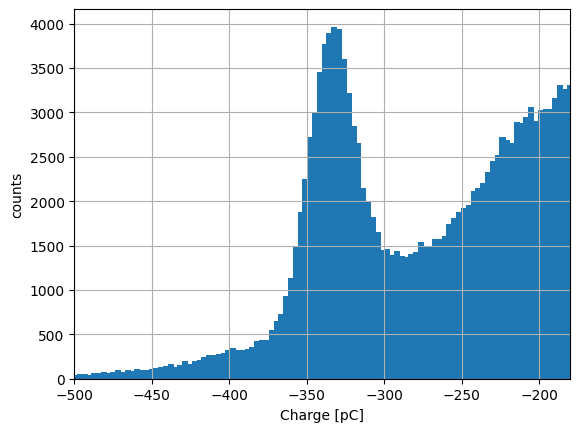

In [40]:
lim_list = [[-700, -165],  #ch0
            [-600, -155],  #ch1
            [-650, -175],  #ch2
            [-600, -145],  #ch3
            [-600, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.bar(centersCs, binCs, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [41]:
with open('/Users/martinachirico/Desktop/Sfera/DictNoise/NoisesDict_11_04.pkl', 'rb') as f:   #lista di dizionari
    x = pickle.load(f)  

In [42]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac

params=x[channel]
print(type(params))
params.pretty_print()
print(params["e1_amplitude"].stderr)


def to_ufloat(var):
    return ufloat(var.value, var.stderr)

def get_constraints(r, n_sigma):
    r["e1_decay"].set(value=r["e1_decay"].value, min=r["e1_decay"].value-n_sigma*r["e1_decay"].stderr, max=r["e1_decay"].value+n_sigma*r["e1_decay"].stderr )
    r["s1_center"].set ( value=r["s1_center"].value, min=r["s1_center"].value-n_sigma*r["s1_center"].stderr, max=r["s1_center"].value+n_sigma*r["s1_center"].stderr)
    r["s1_sigma"].set(value=r["s1_sigma"].value, min=r["s1_sigma"].value-n_sigma*r["s1_sigma"].stderr, max=r["s1_sigma"].value+n_sigma*r["s1_sigma"].stderr )
    r["ratio"].set( vary=True, min=r["ratio"].value-n_sigma*r["ratio"].stderr, max=r["ratio"].value+n_sigma*r["ratio"].stderr)  
    r["s1_amplitude"].set(expr="e1_amplitude/ratio")
    n_sigma=5
    return r


params=get_constraints(params, n_sigma=5)
params.pretty_print()


<class 'lmfit.parameter.Parameters'>
Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      8835     -inf      inf    142.2     True     None     None
e1_decay        -89.38     -inf      inf    0.579     True     None     None
ratio            27.03     -inf      inf   0.7361    False e1_amplitude / s1_amplitude     None
s1_amplitude     326.9        0      inf    6.576     True     None     None
s1_center       -400.8     -inf      inf     1.05     True     None     None
s1_sigma         24.04        0      inf   0.7725     True     None     None
142.16009067473212
Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      8835     -inf      inf    142.2     True     None     None
e1_decay        -89.38   -92.27   -86.48    0.579     True     None     None
ratio            27.03    23.35    30.71   0.7361     True     None     None
s1_amplitude     326.9        0      inf    6.576    False e1_amplitude/ra

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      1000     -inf      inf    142.2     True     None     None
e1_decay        -89.38   -92.27   -86.48    0.579     True     None     None
g2_amplitude  1.361e+06     -inf      inf     None     True     None     None
g2_center         -388     -inf      inf     None     True     None     None
g2_fwhm          44.74     -inf      inf     None    False 2.3548200*g2_sigma     None
g2_height     2.858e+04     -inf      inf     None    False 0.3989423*g2_amplitude/max(1e-15, g2_sigma)     None
g2_sigma            19        0      inf     None     True     None     None
ratio            27.03    23.35    30.71   0.7361     True     None     None
s1_amplitude        37        0      inf    6.576    False e1_amplitude/ratio     None
s1_center       -400.8   -406.1   -395.6     1.05     True     None     None
s1_sigma         24.04    20.18    27.91   0.7725     True     None     None
s2_amplitude     

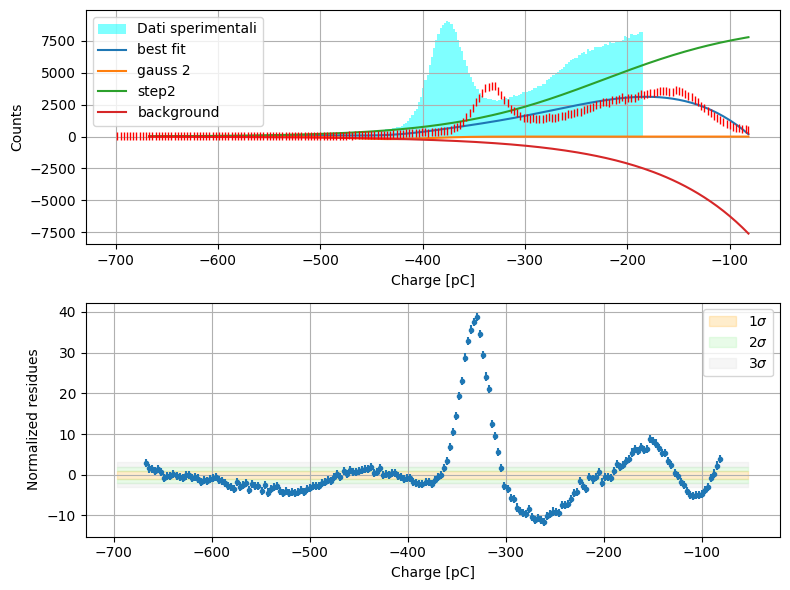

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 24000
    # data points      = 190
    # variables        = 11
    chi-square         = 13808.2831
    reduced chi-square = 77.1412463
    Akaike info crit   = 836.339970
    Bayesian info crit = 872.057235
    R-squared          = 0.99995664
##  Warning: uncertainties could not be estimated:
[[Variables]]
    e1_amplitude: -18392.8540 (init = 1000)
    e1_decay:     -92.2648037 (init = -89.37712)
    s1_amplitude:  0.00000000 == 'e1_amplitude/ratio'
    s1_center:    -406.024080 (init = -400.832)
    s1_sigma:      27.8270047 (init = 24.04369)
    ratio:         24.4620129 (init = 27.02862)
    g2_amplitude: -18291.4943 (init = 1360916)
    g2_center:    -429.853752 (init = -388)
    g2_sigma:      36.7752402 (init = 19)
    g2_fwhm:    

In [43]:

#params["e1_decay"].set(value=r.uvars["e1_decay"].n, min=r.uvars["e1_decay"].n-n_sigma*r.uvars["e1_decay"].s, max=r.uvars["e1_decay"].n+n_sigma*r.uvars["e1_decay"].s)
params["e1_amplitude"].set(value=1000)

params.update(gauss2.guess(binCs, x=centersCs))
params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -388, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))
params["s2_amplitude"].set( value=2844, min=0,  vary=True) #"""value=921"""
params["s2_center"].set(value=-270,  vary=True)
params["s2_sigma"].set(value=9,  vary=True)

#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/'+str(frac))
#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/frac')
#params["s1_center"].set(value=r.uvars["s1_center"].n, min=r.uvars["s1_center"].n-n_sigma*r.uvars["s1_center"].s, max=r.uvars["s1_center"].n+n_sigma*r.uvars["s1_center"].s)
#params["s1_sigma"].set(value=r.uvars["s1_sigma"].n, min=r.uvars["s1_sigma"].n-n_sigma*r.uvars["s1_sigma"].s, max=r.uvars["s1_sigma"].n+n_sigma*r.uvars["s1_sigma"].s)


model = exp1 + s1 + gauss2 +s2

params.pretty_print()

Nbin=200
start=int(Nbin *5/ 100)
stop=int(Nbin * 100/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
#ax1.plot(centersCs[start:stop], comps['e1_'],'.-',label='exp 1')
#ax1.plot(centersCs[start:stop], comps['s1_'], '.-', label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')
ax1.plot(centersCs[start:stop], comps['s1_']+comps['e1_'], label='background')



ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [ ]:
params.add("frac", value = frac.n, min=frac.n-n_sigma*frac.s, max=frac.n +n_sigma*frac.s)
print(params["frac"])
params.update(result.params)
r=result

frac=to_ufloat(result.uvars["e1_amplitude"] / to_ufloat(result.uvars["s1_amplitude"]))
print("rapporto tra le ampiezze di exp e fermi dirac", frac)

1
[-500, -180]


Text(0, 0.5, 'counts')

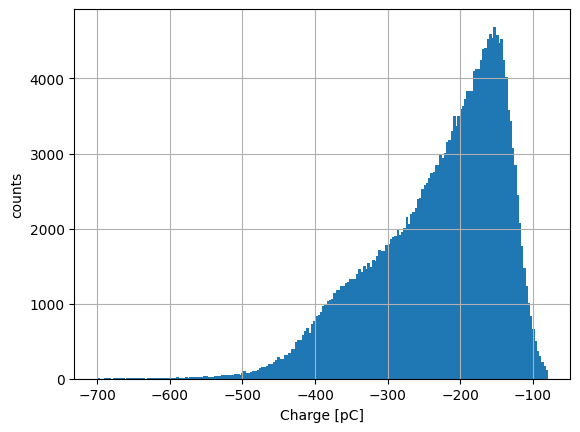

In [60]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


edge_N, bin_N = load_histo("../Dati/Run_ch7_300k_X_ChargeHistos_4_11_2024.dat")

print(len(bin_N))

channel = 0

    
edge_N = edge_N[channel]
bin_N = bin_N[channel]

if(channel == 12 or channel == 13):
    exit()
if(channel > 11):
    channel = channel -2
    

rebin_fact = 5
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

binN=bin_N
centersN = np.convolve(edge_N, [0.5, 0.5], "valid")
errN = np.sqrt(bin_N)

lim_list = [[-700, -165],  #ch0
            [-600, -155],  #ch1
            [-650, -175],  #ch2
            [-600, -145],  #ch3
            [-600, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lims = lim_list[7]
print(lims)
plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


28 160
10.0


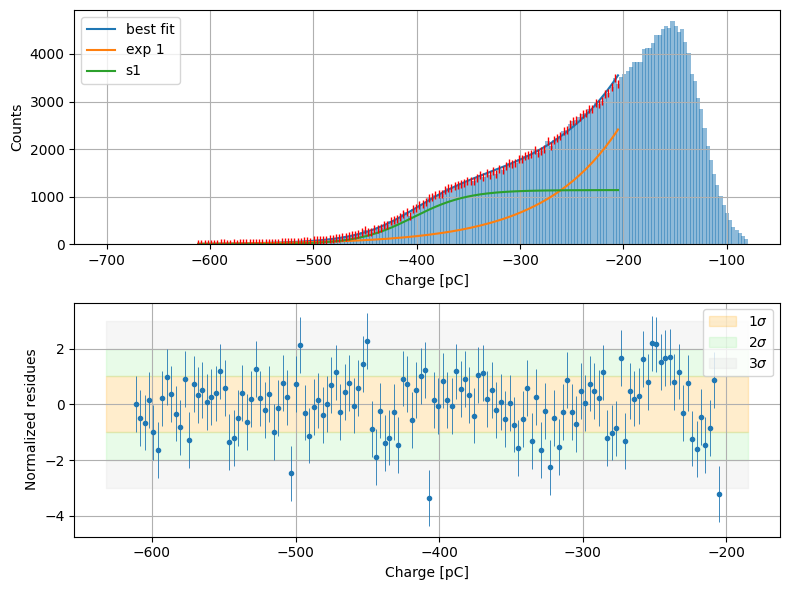

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 132
    # variables        = 5
    chi-square         = 143.556353
    reduced chi-square = 1.13036499
    Akaike info crit   = 21.0781978
    Bayesian info crit = 35.4922074
    R-squared          = 0.99999894
[[Variables]]
    e1_amplitude:  39445.1199 +/- 1263.72886 (3.20%) (init = 29152.68)
    e1_decay:     -73.4414264 +/- 0.84188323 (1.15%) (init = -83.22036)
    g2_amplitude:  1360916 (fixed)
    g2_center:    -220.5678 (fixed)
    g2_sigma:      114.7 (fixed)
    g2_fwhm:       270.097854 +/- 0.00000000 (0.00%) == '2.3548200*g2_sigma'
    g2_height:     4733.45039 +/- 0.00000000 (0.00%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_amplitude:  1138.62393 +/- 23.5437808 (2.07%) (init = 100)
    s1_center:    -403.124916 +/- 1.08566420 (0.27%) (init = -370)
    s1_sigma:    

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,39445.1199,1263.72886,(3.20%),29152.67877955851,0.00000000,inf,True,
e1_decay,-73.4414264,0.84188323,(1.15%),-83.22035898314351,-inf,inf,True,
g2_amplitude,1360915.50,0.00000000,(0.00%),1360915.5,-inf,inf,False,
g2_center,-220.567778,0.00000000,(0.00%),-220.56777777777776,-inf,inf,False,
g2_sigma,114.700000,0.00000000,(0.00%),114.7,0.00000000,inf,False,
g2_fwhm,270.097854,0.00000000,(0.00%),270.09785400000004,-inf,inf,False,2.3548200*g2_sigma
g2_height,4733.45039,0.00000000,(0.00%),4733.4503895,-inf,inf,False,"0.3989423*g2_amplitude/max(1e-15, g2_sigma)"
s1_amplitude,1138.62393,23.5437808,(2.07%),100.0,-inf,inf,True,
s1_center,-403.124916,1.08566420,(0.27%),-370.0,-inf,inf,True,
s1_sigma,26.4307192,0.69748129,(2.64%),20,5.00000000,inf,True,


In [74]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
#gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss2.make_params(amplitude = 1000, center = -370, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(gauss2.guess(binCs, x=centersCs))
params.update(s1.make_params(amplitude = 100, center = -370, sigma = 20))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit) 
params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))



params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

params["s2_amplitude"].vary= False
params["s2_center"].vary=False
params["s2_sigma"].vary=False

params["e1_amplitude"].min=0
params["s1_sigma"].set(value=20, min=5)

model = exp1 + s1 

# Fit the model to the data
start=int(0.14*len(binN))
stop=int(0.80*len(binN))
print(start, stop)
print(binN[start])
result = model.fit(binN[start:stop], params, x = centersN[start:stop], weights = 1/errN[start:stop], nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.bar(centers_N, bin_N, width = 4, alpha=0.5)
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN[start:stop], result.best_fit, label='best fit')
ax1.plot(centersN[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersN[start:stop], comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN[start:stop], binN[start:stop], errN[start:stop], color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN[start:stop] - result.best_fit
norm_resN = residueN / errN[start:stop]

ax2.errorbar(centersN[start:stop], norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["s1_amplitude"].value
print(frac)
params.update(result.params)

In [56]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(s1.make_params(amplitude = 100, center = -380, sigma = 50))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
params = gauss2.guess(binN, x=centersN)
params=s2.guess(binN, x=centersN)




params["e1_amplitude"].min=0
params["s1_sigma"].set(value=20, min=0)

model = exp1 + s1 

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(binN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(result.fit_report())





KeyError: 'e1_amplitude'

# Vecchio fit del rumore

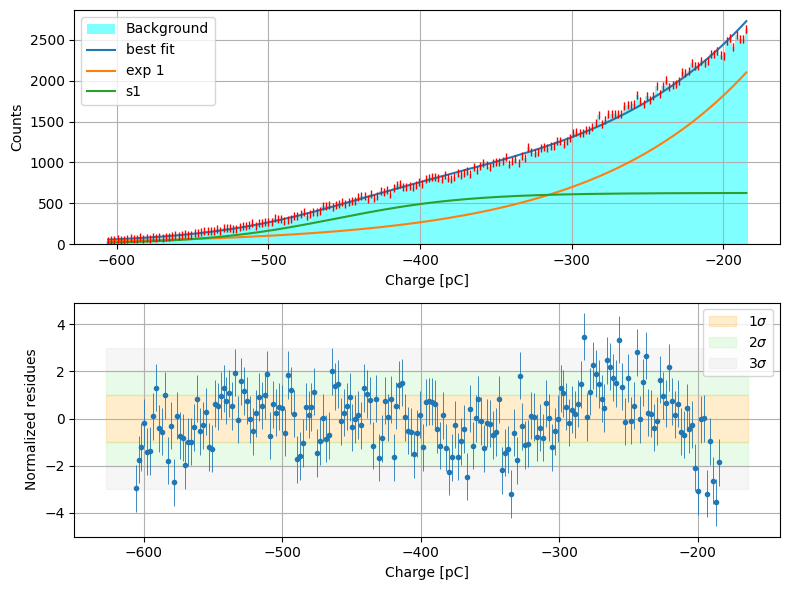

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 200
    # variables        = 5
    chi-square         = 312.227945
    reduced chi-square = 1.60116895
    Akaike info crit   = 99.0832293
    Bayesian info crit = 115.574816
    R-squared          = 0.99999701
[[Variables]]
    e1_amplitude:  12334.5386 +/- 714.775621 (5.79%) (init = 18356.11)
    e1_decay:     -104.482254 +/- 4.79111514 (4.59%) (init = -114.6268)
    g2_amplitude:  2442417 (fixed)
    g2_center:    -288.0907 (fixed)
    g2_sigma:      114.201 (fixed)
    g2_fwhm:       268.922844 +/- 0.00000000 (0.00%) == '2.3548200*g2_sigma'
    g2_height:     8532.17897 +/- 0.00000000 (0.00%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_amplitude:  627.736697 +/- 62.4765290 (9.95%) (init = 100)
    s1_center:    -455.329142 +/- 3.42570038 (0.75%) (init = -380)
    s1_sigma:  

In [31]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
#gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
#params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 1000, center = -370, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(gauss2.guess(binCs, x=centersCs))
params.update(s1.make_params(amplitude = 100, center = -380, sigma = 50))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)
#params.update(gauss1.guess(binN, x=centersN)) 
params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))



params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

params["s2_amplitude"].vary= False
params["s2_center"].vary=False
params["s2_sigma"].vary=False

params["e1_amplitude"].min=0
params["s1_sigma"].set(value=20, min=0)

model = exp1 + s1 

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(result.fit_report())

def to_ufloat(var):
    return ufloat(var.n, var.s)


frac=to_ufloat(result.uvars["e1_amplitude"] / to_ufloat(result.uvars["s1_amplitude"]))
print("rapporto tra le ampiezze di exp e fermi dirac", frac)
n_sigma=5
params.add("frac", value = frac.n, min=frac.n-n_sigma*frac.s, max=frac.n +n_sigma*frac.s)
print(params["frac"])
params.update(result.params)
r=result


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      1000        0      inf    714.8     True     None     None
e1_decay        -104.5   -128.4   -80.53    4.791     True     None     None
frac             19.65    8.334    30.96     None     True     None     None
g2_amplitude  2.442e+06     -inf      inf        0     True     None     None
g2_center         -388     -inf      inf        0     True     None     None
g2_fwhm          44.74     -inf      inf        0    False 2.3548200*g2_sigma     None
g2_height     5.128e+04     -inf      inf        0    False 0.3989423*g2_amplitude/max(1e-15, g2_sigma)     None
g2_sigma            19        0      inf        0     True     None     None
s1_amplitude     50.89     -inf      inf    62.48    False e1_amplitude/frac     None
s1_center       -455.3   -472.5   -438.2    3.426     True     None     None
s1_sigma         43.22    25.57    60.87     3.53     True     None     None
s2_amplitude      

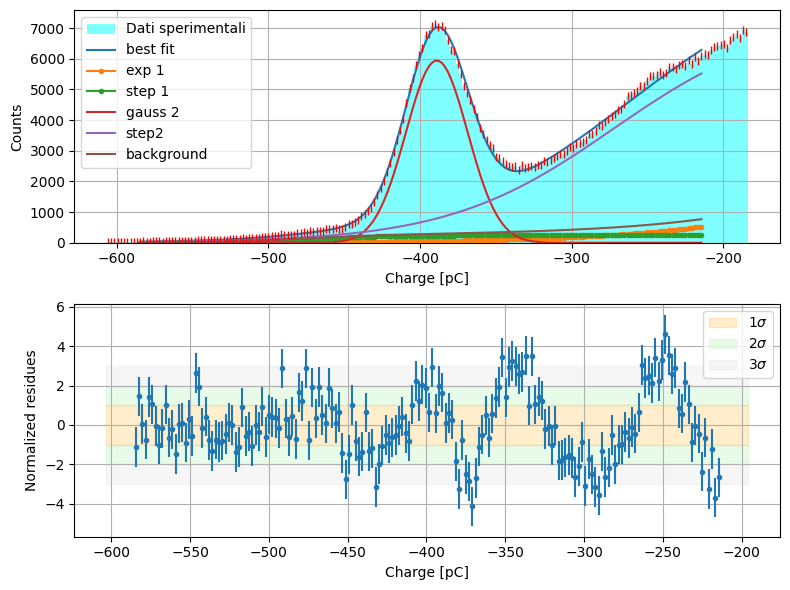

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 594
    # data points      = 176
    # variables        = 11
    chi-square         = 527.692155
    reduced chi-square = 3.19813428
    Akaike info crit   = 215.253118
    Bayesian info crit = 250.128442
    R-squared          = 0.99999943
[[Variables]]
    e1_amplitude:  7532.62220 +/- 29536.0188 (392.11%) (init = 1000)
    e1_decay:     -80.5266796 +/- 1.3411e+08 (166544125.32%) (init = -104.4823)
    g2_amplitude:  303165.626 +/- 5152.22241 (1.70%) (init = 2442417)
    g2_center:    -388.968217 +/- 0.14455118 (0.04%) (init = -388)
    g2_sigma:      20.3415275 +/- 0.21336628 (1.05%) (init = 19)
    g2_fwhm:       47.9006357 +/- 0.50243919 (1.05%) == '2.3548200*g2_sigma'
    g2_height:     5945.74779 +/- 59.7780714 (1.01%) == '0.398942

In [100]:

params["e1_decay"].set(value=r.uvars["e1_decay"].n, min=r.uvars["e1_decay"].n-n_sigma*r.uvars["e1_decay"].s, max=r.uvars["e1_decay"].n+n_sigma*r.uvars["e1_decay"].s)
params["e1_amplitude"].set(value=1000)

params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -388, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params["s2_amplitude"].set( value=1000, min=0,  vary=True) #"""value=921"""
params["s2_center"].set(value=-250,  vary=True)
params["s2_sigma"].set(value=5,  vary=True)

#params["s1_amplitude"].set(vary = True, expr='e1_amplitude/'+str(frac))
params["s1_amplitude"].set(vary = True, expr='e1_amplitude/frac')
params["s1_center"].set(value=r.uvars["s1_center"].n, min=r.uvars["s1_center"].n-n_sigma*r.uvars["s1_center"].s, max=r.uvars["s1_center"].n+n_sigma*r.uvars["s1_center"].s)
params["s1_sigma"].set(value=r.uvars["s1_sigma"].n, min=r.uvars["s1_sigma"].n-n_sigma*r.uvars["s1_sigma"].s, max=r.uvars["s1_sigma"].n+n_sigma*r.uvars["s1_sigma"].s)


model = exp1 + s1 + gauss2 +s2

params.pretty_print()

start=int(Nbin *5/ 100)
stop=int(Nbin * 93/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'],'.-',label='exp 1')
ax1.plot(centersCs[start:stop], comps['s1_'], '.-', label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')
ax1.plot(centersCs[start:stop], comps['s1_']+comps['e1_'], label='background')



ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())